In [1]:
import sys
import os
import cv2
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from numpy import pi, matmul,sqrt,dot,array,zeros,cos,sin,pi,arccos
from torch.utils.data import DataLoader
from func import OR,heatplot,misorientation,classplot,ipfplot,ipfread,negsample
from func2 import create_dataset
from Class import Data,Cluster,Dataset,CNN49ag,CNN49bg
import torch.nn.functional as F
import matplotlib.patches as patches

In [2]:
model_path="model/CNN_49g_all/0.824_CNN49bg_BC_BS_Error.pkl"
feature=model_path.replace(".pkl","").split("/")[-1].split("_")[2:]
header=['ND面硬度(Hv)', 'TD面硬度(Hv)', 'UTS strain(%)', 'UTS stress(MPa)','Total Elongation(%)', 'E(GPa)', 'Ys(Mpa)']
pic_size=499
sam_size=49
# train=create_dataset("train",steels=["590","780","980"],feature=feature,prop_dic=prop_dic,pic_size=pic_size,
#                      sam_size=sam_size,prediction=1)
# val=create_dataset("val",steels=["590","780","980"],feature=feature,prop_dic=prop_dic,pic_size=pic_size,
#                      sam_size=sam_size,prediction=1)
# test=create_dataset("test",steels=["590","780","980"],feature=feature,prop_dic=prop_dic,pic_size=pic_size,
#                      sam_size=sam_size,prediction=1)
# data=torch.cat([train[0],val[0],test[0]])
# props=torch.cat([train[1],val[1],test[1]])
# src=train[2]+val[2]+test[2]
# torch.save([data,props,src],"ata/data.pkl")
m1 = torch.load(model_path)
m1.eval()
data,props,src=torch.load("data/data.pkl")

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.MaxPool2d' has changed. you can retrieve the original source code by accessing the object's sourc

In [7]:
h=w=499
ks=49
num=data.shape[0]
pred=np.zeros([data.shape[0],h-ks+1,w-ks+1])
for i in range(h-ks+1):
    for j in range(w-ks+1):
        output=m1(data[:,:,i:i+ks,j:j+ks],props)
        for k in range(num):
            pred[k,i,j]+=output[k,0].item()
        del output
                

In [3]:
# torch.save(pred,"output/pred.pkl")
pred=torch.load("output/pred.pkl")

(<matplotlib.image.AxesImage at 0x1cf2b66e148>,
 'data/780/test/20201109/before/')

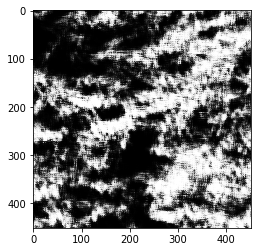

In [4]:
plt.imshow(pred[-1],cmap="gray"),src[-1]

In [3]:
prob=np.zeros([2]) #ferrite,martensite
pixels=np.zeros([2])        
for mode in ["train","test"]:
    pred=torch.load("output/"+mode+"_pred.pkl")
    for ind,date in enumerate(sorted(os.listdir("data/"+mode+"/"))):
        class_map,id2clus,ma_id=torch.load("data/"+mode+"/"+date+"/before/cluster.pkl")
        break
        pad=24
        for i in range(h-ks+1):
            for j in range(w-ks+1):
                if class_map[pad+i,pad+j] in ma_id:
                    prob[1]+=pred[ind,i,j]
                    pixels[1]+=1
                else:
                    prob[0]+=pred[ind,i,j]
                    pixels[0]+=1
print(prob/pixels)
        

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


[nan nan]


In [39]:
#0 ferrite in ferrite
#1 ferrite in ferrite bd
#2 ferrite in martensite bd
#3 martensite in martensite
#4 martensite in ferrite bd
h=w=499
ks=49
num=pred.shape[0]
prob=np.zeros([5]) #ferrite,martensite
pixels=np.zeros([5])        
pad=24
neigh=np.array([[1,0],[-1,0],[0,1],[0,-1]])
for mode in ["train","test"]:
    pred=torch.load("output/"+mode+"_pred.pkl")
    for ind,date in enumerate(sorted(os.listdir("data/"+mode+"/"))):
        class_map,id2clus,ma_id=torch.load("data/"+mode+"/"+date+"/before/cluster.pkl")
        for i in range(h-ks+1):
            for j in range(w-ks+1):
                types=[]
                if class_map[pad+i,pad+j] in ma_id:
                    for (n0,n1) in neigh:
                        if class_map[pad+i+n0,pad+j+n1] in ma_id:
                            types.append(3)
                        else:
                            types.append(4)
                else:
                    for (n0,n1) in neigh:
                        if class_map[pad+i+n0,pad+j+n1] in ma_id:
                            types.append(2)
                        else:
                            if class_map[pad+i+n0,pad+j+n1]==class_map[pad+i,pad+j]:
                                types.append(0)
                            else:
                                types.append(1)
                for ele in types:
                    prob[ele]+=pred[ind,i,j]
                    pixels[ele]+=1



In [40]:
# output=torch.load("output/test_map.pkl")
# torch.save(new_map_2,"output/test_map.pkl")
pd.DataFrame(np.array([prob.tolist(),pixels.tolist()]),columns=["f in f","f in fbd","f in mbd","m in m","m in fbd"]).to_excel("output/edge_analysis.xlsx")

In [41]:
#0 ferrite in ferrite
#1 ferrite in ferrite bd
#2 ferrite in martensite bd
#3 ferrite in martensite bd and ferrite bd
#4 martensite in martensite
#5 martensite in ferrite bd
h=w=499
ks=49
num=pred.shape[0]
prob=np.zeros([6]) #ferrite,martensite
pixels=np.zeros([6])        
pad=24
neigh=np.array([[1,0],[-1,0],[0,1],[0,-1]])
for mode in ["train","test"]:
    pred=torch.load("output/"+mode+"_pred.pkl")
    for ind,date in enumerate(sorted(os.listdir("data/"+mode+"/"))):
        class_map,id2clus,ma_id=torch.load("data/"+mode+"/"+date+"/before/cluster.pkl")
        for i in range(h-ks+1):
            for j in range(w-ks+1):
                types=[]
                if class_map[pad+i,pad+j] in ma_id:
                    for (n0,n1) in neigh:
                        if class_map[pad+i+n0,pad+j+n1] in ma_id:
                            types.append(4)
                        else:
                            types.append(5)
                    if 5 in types:
                        prob[5]+=pred[ind,i,j]
                        pixels[5]+=1
                    else:
                        prob[4]+=pred[ind,i,j]
                        pixels[4]+=1
                else:
                    for (n0,n1) in neigh:
                        if class_map[pad+i+n0,pad+j+n1] in ma_id:
                            types.append(2)
                        else:
                            if class_map[pad+i+n0,pad+j+n1]==class_map[pad+i,pad+j]:
                                types.append(0)
                            else:
                                types.append(1)
                    if 1 in types and 2 in types:
                        prob[3]+=pred[ind,i,j]
                        pixels[3]+=1
                    elif 1 in types:
                        prob[1]+=pred[ind,i,j]
                        pixels[1]+=1
                    elif 2 in types:
                        prob[2]+=pred[ind,i,j]
                        pixels[2]+=1
                    else:
                        prob[0]+=pred[ind,i,j]
                        pixels[0]+=1
                        



In [45]:
pd.DataFrame(np.array([prob.tolist(),pixels.tolist()]),columns=["f in f","f in fbd","f in mbd","f in fmbd","m in m","m in fbd"]).to_excel("output/pixel_analysis.xlsx")

In [11]:
# plt.imshow(output[1],cmap="gray")
# plt.axis("off")
# plt.show()
# plt.imshow(new_map[1],cmap="gray")
# plt.savefig("output/20201109_451451.png",bbox_inches='tight',pad_inches=0,dpi=600)


True

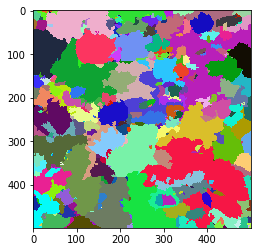

True

In [18]:
index=-1
sum_map=pred[index]
cv2.imwrite("output/20201109_451451.png",sum_map*255)
cv2.imwrite("output/20201109_451451_inv.png",(1-sum_map)*255)
class_map,id2clus,ma_id=torch.load(src[index]+"cluster.pkl")
class_img=classplot(class_map)[24:475,24:475,:]
ipf=ipfread(src[index])[24:475,24:475,6:]
cv2.imwrite("output/20201109_class.png",class_img)
cv2.imwrite("output/20201109_ipf_b.png",ipf)
for i in range(3):
    ipf[:,:,i]=np.multiply(1-sum_map,ipf[:,:,i])
    class_img[:,:,i]=np.multiply(1-sum_map,class_img[:,:,i])
cv2.imwrite("output/20201109_ipf_d.png",ipf)
cv2.imwrite("output/20201109_class_d.png",class_img)

# plt.imshow(1-new_map[0],cmap="gray")
# plt.imshow(ipf[:,:,6:][...,[2,1,0]].astype("int"),alpha=0.5)
# plt.axis('off')


(451, 451)